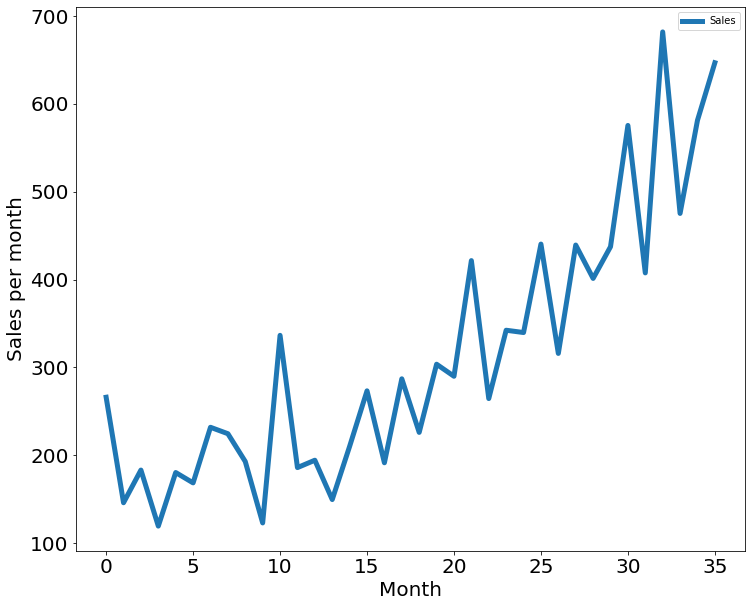

In [1]:
#shift+enter task
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from pmdarima.arima import ADFTest
import pmdarima as pmd
from sklearn.metrics import r2_score
# читаем input-файл
df = pd.read_csv('shampoo_sales.csv')
sales = df[['Sales']]
sales.plot(figsize=(12,10), linewidth=5, fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Sales per month', fontsize=20)
plt.show()
df.set_index('Month', inplace=True)

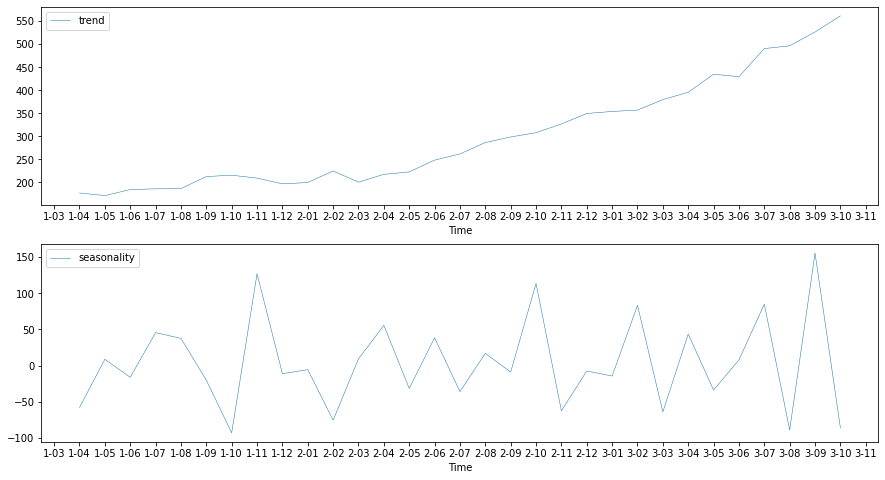

In [2]:
df['Sales'].rolling(6, center=True).mean()
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
ax[0].plot(df['Sales'].rolling(6, center=True).mean(), linewidth = 0.5, label='trend')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('')
ax[0].legend(loc='best')

seasons = df['Sales'] - df['Sales'].rolling(6, center=True).mean()
ax[1].plot(seasons, linewidth = 0.5, label='seasonality')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('')
ax[1].legend(loc='best')
plt.show()
# У тренда четкая тендеция к росту
# Сезонность предположительно составляет 11 месяцев

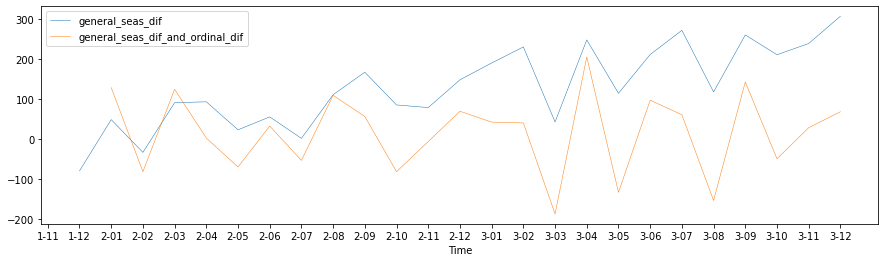

In [3]:
general_seas_dif = df['Sales']-df['Sales'].shift(11)
# Продифференцировали по сезонности, ряд остался нестационарным (виден тренд)
general_seas_dif_and_ordinal_dif = general_seas_dif-general_seas_dif.shift(1)
# Продифференцировали обычным образом, ряд стал стационарным
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(general_seas_dif, linewidth = 0.5, label='general_seas_dif')
ax.plot(general_seas_dif_and_ordinal_dif, linewidth = 0.5, label='general_seas_dif_and_ordinal_dif')
ax.set_xlabel('Time')
ax.set_ylabel('')
ax.legend(loc='best')

plt.show()

In [4]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(general_seas_dif_and_ordinal_dif.dropna())
# Проверили стацинарность нового ряда тестом Дики-Фуллера

(0.030453982253605683, False)

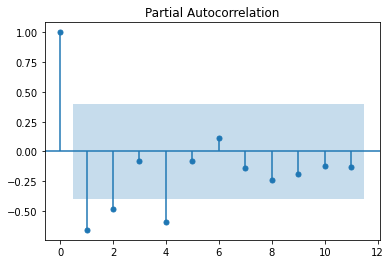

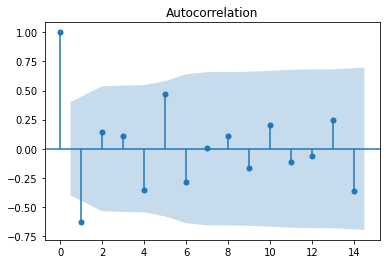

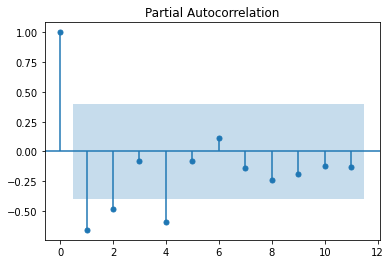

In [7]:
# Подбираем параметры для модели
sm.graphics.tsa.plot_acf(general_seas_dif_and_ordinal_dif[12:])
sm.graphics.tsa.plot_pacf(general_seas_dif_and_ordinal_dif[12:], lags=11)

In [10]:
size = int(len(sales) * 0.6)
sales = df['Sales']
train_set, test_set = sales.values[0:size], sales.values[size:len(sales)]
history = [x for x in train_set]
predictions = list()
series = pd.read_csv('shampoo_sales.csv' , index_col = 0)

In [11]:
arima_model = pmd.auto_arima(train_set, max_p=2, max_P=1, d = 1, D=1, m=11, start_q=0, max_q=1, max_Q=1, test="adf", seasonal=True, supress_warnings = True, trace=True, stepwise = False, dynamic=False)
arima_model.summary()

 ARIMA(0,1,0)(0,1,0)[11]             : AIC=107.176, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[11]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[11]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(1,1,1)[11]             : AIC=111.116, Time=0.66 sec
 ARIMA(0,1,1)(0,1,0)[11]             : AIC=107.449, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[11]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(1,1,0)[11]             : AIC=109.386, Time=0.70 sec
 ARIMA(0,1,1)(1,1,1)[11]             : AIC=111.386, Time=0.84 sec
 ARIMA(1,1,0)(0,1,0)[11]             : AIC=107.180, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[11]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(1,1,0)[11]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(1,1,1)[11]             : AIC=110.882, Time=0.77 sec
 ARIMA(1,1,1)(0,1,0)[11]             : AIC=109.180, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[11]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(1,1,0)[11]             : AIC=110.884, Time=0.81 sec
 ARIMA(1,1,1)(1,1,1)[11]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   21
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 11)   Log Likelihood                 -52.588
Date:                            Sun, 01 Aug 2021   AIC                            107.176
Time:                                    00:53:17   BIC                            107.373
Sample:                                         0   HQIC                           106.750
                                             - 21                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6954.9442   5518.564      1.260      0.208   -3861.243    1.78e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.85   Jarque-Bera (JB):                 0.86
Prob(Q):                              0.09   Prob(JB):                         0.65
Heteroskedasticity (H):               0.46   Skew:                            -0.06
Prob(H) (two-sided):                  0.55   Kurtosis:                         1.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
predictions = arima_model.predict(n_periods = len(sales)-size,typ = 'levels', dynamic=True)
print("r2_score", r2_score(test_set, predictions))
# r2_score не отрицательно, что хорошо

r2_score 0.5605961363370493


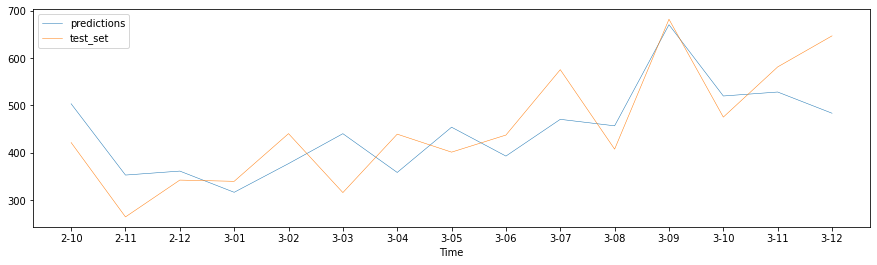

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(predictions, linewidth = 0.5, label='predictions')
ax.plot(sales[size:len(sales)], linewidth = 0.5, label='test_set')
ax.set_xlabel('Time')
ax.legend(loc='best')
plt.show()